In [20]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, precision_score, f1_score

In [21]:
# Cargando dataset
file_path = 'dataset/anaemia.csv' 
df = pd.read_csv(file_path)

In [22]:
# Eliminando espacios en blanco en la columna Sex
df['Sex'] = df['Sex'].str.strip()

encoder = LabelEncoder()

df['Sex'] = encoder.fit_transform(df['Sex'])

df['Anaemic'] = encoder.fit_transform(df['Anaemic'])

In [23]:
# Seleccionando  variables independientes y variable objetivo
X = df[['Number', 'Sex', '%Red Pixel', '%Green pixel', '%Blue pixel', 'Hb']]
y = df['Anaemic']

In [24]:
# Separando los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=314)

In [25]:
# Creando modelo Random Forest
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=314)

# Escalando datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Entrenando modelo
random_forest_model.fit(X_train_scaled, y_train)

# Prediciendo valores
y_pred = random_forest_model.predict(X_test_scaled)

In [26]:
# Evaluando modelo
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        25
           1       1.00      1.00      1.00         7

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32

[[25  0]
 [ 0  7]]


In [27]:
print(f"Recall: {recall_score(y_test, y_pred):.2f}")
print(f"Precision: {precision_score(y_test, y_pred):.2f}")
print(f"F1 Score: {f1_score(y_test, y_pred)}")

Recall: 1.00
Precision: 1.00
F1 Score: 1.0


In [28]:
kfold = KFold(n_splits=5, shuffle=True, random_state=314)

results = cross_val_score(random_forest_model, X, y, cv=kfold, scoring='accuracy')
print(f"Accuracy: {results.mean():.2f} (+/- {results.std():.2f})")

Accuracy: 0.96 (+/- 0.04)


# Analisis SHAP

In [29]:
import seaborn as sns
import shap
import numpy as np
shap.initjs()

In [30]:
explainer = shap.TreeExplainer(random_forest_model)
shap_values = np.array(explainer.shap_values(X_train_scaled))
shap_values.shape

(72, 6, 2)

In [31]:
shap_values_ = shap_values.transpose(2, 0, 1)
shap_values_.shape

(2, 72, 6)

## SHAP Summary Plot

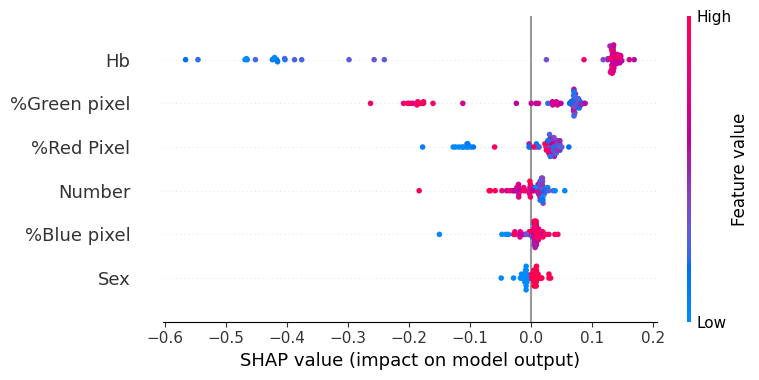

In [32]:
shap.summary_plot(shap_values_[0],X_train_scaled)

En este caso, al predecir que la persona no tiene anemia, la variable Hb es la más influyente en el modelo de predicción. Por tanto, a mayor nivel de emoglobina, mayor es la probabilidad de que la persona no tenga anemia. Además, según la dispersión de los puntos de esta variable,  se puede interpretar que hay una variabialidad en el impacto de esta variable en las predicciones del modelo. 

Por otra parte, el pixel azul es el pixel menos influyente en el modelo y muestra poca dispersión, lo que indica que la variable afecta de forma similar a las predicciones, al igual la variable sexo, siendo esta la variable menos influyente.

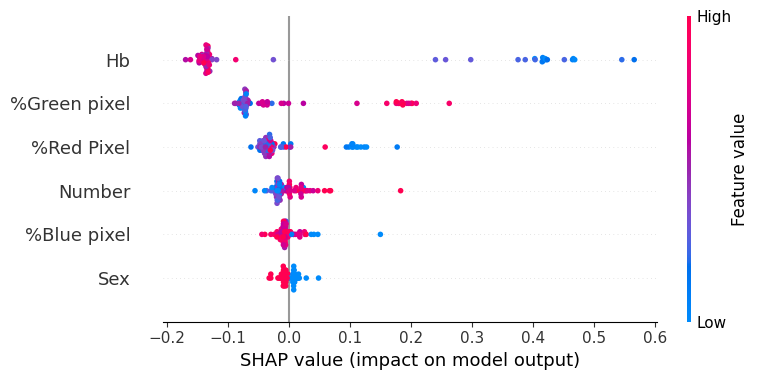

In [33]:
shap.summary_plot(shap_values_[1],X_train_scaled)


En este caso, cuando se predice si la persona si tiene anemia, el orden de influencia de las variables es el mismo que cuando se predice si una persona no tiene anemia. Al tener la variable Hb un mayor valor negativo, se puede interpretar que a mayor nivel de emoglobina, menor es la probabilidad de que la persona tenga anemia.

## SHAP Dependence Plots

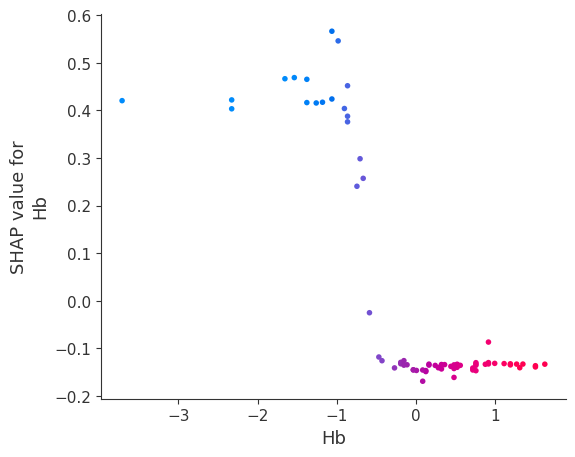

In [34]:
# SHAP dependence plot - Analizando como la variable Hb afecta a la predecir si un paciente tiene anemia
shap.dependence_plot('Hb', shap_values_[1], X_train_scaled, interaction_index='Hb')

Hb tiene un impacto significativo en la predicción de que un paciente tenga anemia, especialmente cuando la persona tiene niveles de Hb bajos.

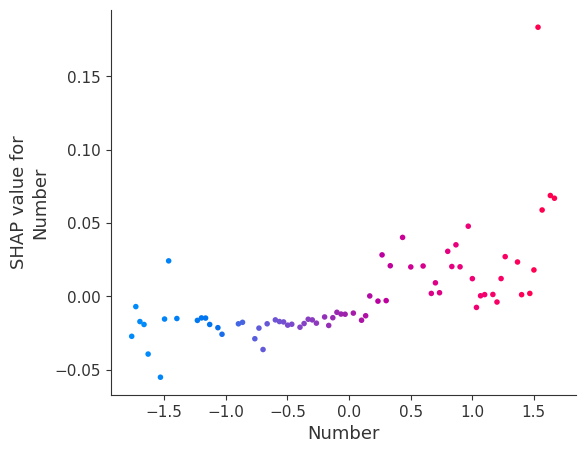

In [35]:
# SHAP dependence plot - Analizando como la variable Number afecta a la predicción del modelo
shap.dependence_plot('Number', shap_values_[1], X_train_scaled, interaction_index='Number')

Los valores menores a 0 de la variable Number muestran un impacto mínimo en la predicción del modelo. Sin embargo, a medida que el valor de la variable Number aumenta, también su impacto en las predicciones del modelo aumenta.

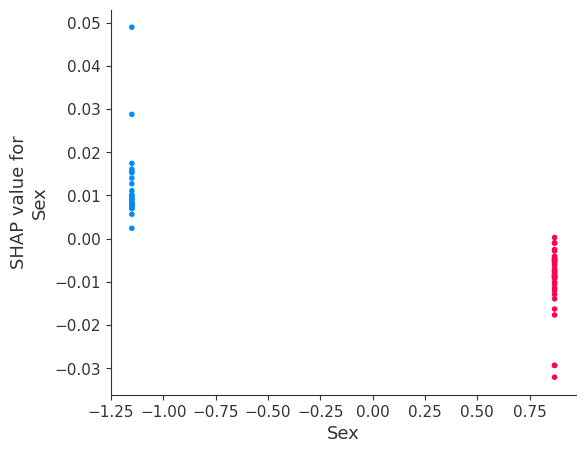

In [36]:
# SHAP dependence plot - Analizando como la variable Sex afecta a la predicción del modelo
shap.dependence_plot('Sex', shap_values_[1], X_train_scaled, interaction_index='Sex')

El impacto de la variable Sex en las predicciones del modelo es relativamente pequeño en comparación con otras variables.

## SHAP Force Plots

In [37]:
class_type = 0
shap_values_subset = shap_values_[class_type][:]
shap.plots.force(explainer.expected_value[class_type], shap_values_subset, X_train_scaled.iloc[:])

La variable Hb es la que más sobresale en las observaciones analizadas, subiendo o bajanda las predicciones dependiendo del caso. Seguida de la variable Green pixel y luego Red Pixel.

In [38]:
class_type = 1
shap_values_subset = shap_values_[class_type][:]
shap.plots.force(explainer.expected_value[class_type], shap_values_subset, X_train_scaled.iloc[:])

La variable Hb es la que más sobresale en las observaciones analizadas, subiendo o bajanda las predicciones dependiendo del caso. Seguida de la variable Green pixel y luego Red Pixel.